### Ideas:
- also train on similar anions/cations-containing systems
    - maybe to do this, I need to make some kind of map
- user input training data: make a pymatgen Structure from it
- maybe store individual results in json file

### Bandgaps:
- Se = 1.5eV
- Cd = 0 eV
- CdSe = 0.559 eV
- CdSe2 = 0.952 eV

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, metrics, linear_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pypredictbandgaps.material import Material
from pypredictbandgaps.bandgappredictions import BandGapPredictions

In [2]:
Cd2Se3 = Material(formula="Cd2Se3",a=3.95,b=3.95,c=3.95)#,alpha=59.99,beta=59.99,gamma=59.99) # mp-1219182
Cd25Se80 = Material(formula="Cd25Se80",a=3,b=3,c=3)#,alpha=59.99,beta=59.99,gamma=59.99) # mp-1219182

Si2Ge3 = Material(formula="Si2Ge3",a=4.12,b=4.12,c=4.12)#,alpha=59.99,beta=59.99,gamma=59.99) # mp-1219182
Si82Ge17 = Material(formula="Si82Ge17",a=3.98,b=3.98,c=3.98)#,alpha=59.99,beta=59.99,gamma=59.99) # mp-1219182
#Si2Ge4 = Material(formula="Si2Ge4")
#Si5Ge2 = Material(formula="Si5Ge2")
#Cu = Material(formula="Cu",a=1,b=1,c=2,alpha=90,beta=90,gamma=90,volume=11.1)

In [8]:
materials_list = [Cd2Se3,Cd25Se80]#[SiGe,Si2Ge4,Si5Ge2]
band_gap_predictions = BandGapPredictions(materials_list)
band_gap_prediction_objects = band_gap_predictions.band_gap_prediction_objects

Connection established to Materials Project database, version 2020_09_08.
... getting mp ids for the chemical system: Cd-Se ...
 getting training data for mp-1183591: 1 of 19 mp ids


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


 getting training data for mp-94: 2 of 19 mp ids
 getting training data for mp-1096861: 3 of 19 mp ids
 getting training data for mp-1183542: 4 of 19 mp ids
 getting training data for mp-2691: 5 of 19 mp ids
 getting training data for mp-1095493: 6 of 19 mp ids
 getting training data for mp-1055: 7 of 19 mp ids
 getting training data for mp-1183665: 8 of 19 mp ids
 getting training data for mp-1070: 9 of 19 mp ids
 getting training data for mp-1009757: 10 of 19 mp ids
 getting training data for mp-7755: 11 of 19 mp ids
 getting training data for mp-12771: 12 of 19 mp ids
 getting training data for mp-147: 13 of 19 mp ids
 getting training data for mp-14: 14 of 19 mp ids
 getting training data for mp-1247808: 15 of 19 mp ids
 getting training data for mp-542461: 16 of 19 mp ids
 getting training data for mp-570481: 17 of 19 mp ids
 getting training data for mp-542605: 18 of 19 mp ids
 getting training data for mp-119: 19 of 19 mp ids
Training the model...
training params= ['a', 'b', 'c'

C:\Users\emily\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ridge regression alpha_choice = 10.0
Making predictions...
prediciton data: [[3.95 3.95 3.95 0.4  0.6 ]]
Connection established to Materials Project database, version 2020_09_08.
... getting mp ids for the chemical system: Cd-Se ...
 getting training data for mp-1183591: 1 of 19 mp ids


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


 getting training data for mp-94: 2 of 19 mp ids
 getting training data for mp-1096861: 3 of 19 mp ids
 getting training data for mp-1183542: 4 of 19 mp ids
 getting training data for mp-2691: 5 of 19 mp ids
 getting training data for mp-1095493: 6 of 19 mp ids
 getting training data for mp-1055: 7 of 19 mp ids
 getting training data for mp-1183665: 8 of 19 mp ids
 getting training data for mp-1070: 9 of 19 mp ids
 getting training data for mp-1009757: 10 of 19 mp ids
 getting training data for mp-7755: 11 of 19 mp ids
 getting training data for mp-12771: 12 of 19 mp ids
 getting training data for mp-147: 13 of 19 mp ids
 getting training data for mp-14: 14 of 19 mp ids
 getting training data for mp-1247808: 15 of 19 mp ids
 getting training data for mp-542461: 16 of 19 mp ids
 getting training data for mp-570481: 17 of 19 mp ids
 getting training data for mp-542605: 18 of 19 mp ids
 getting training data for mp-119: 19 of 19 mp ids
Training the model...
training params= ['a', 'b', 'c'

C:\Users\emily\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ridge regression alpha_choice = 10.0
Making predictions...
prediciton data: [[3.         3.         3.         0.23809524 0.76190476]]


In [9]:
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    print(f""" 
    {material}
    -----------
    model score: {band_gap_prediction_object.model_score}
    band gap: {band_gap_prediction_object.predicted_band_gap} eV""")

 
    Cd2Se3
    -----------
    model score: 0.5353729676705368
    band gap: 0.20646334828698704 eV
 
    Cd25Se80
    -----------
    model score: 0.4862612839575203
    band gap: 0.004966181974576489 eV


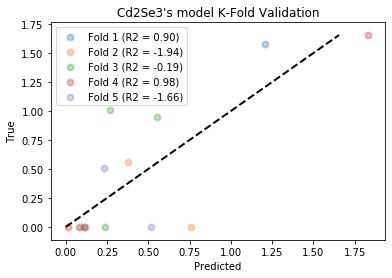

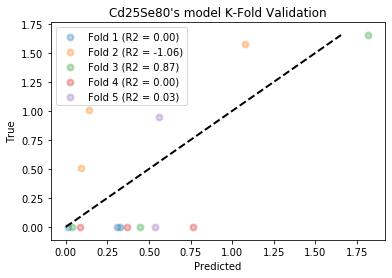

In [10]:
# K fold validation
# https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    scores = list()
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    fig = plt.figure()
    i = 1

    X_train = band_gap_prediction_object.X_train
    y_train = band_gap_prediction_object.y_train
    model = band_gap_prediction_object.model
    
    for train, test in cv.split(X_train, y_train):
        prediction = model.fit(X_train[train],
                        y_train[train]).predict(X_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3, 
                    label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
                linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{material}'s model K-Fold Validation")
    plt.legend()
    plt.show()

In [6]:
feature_names = band_gap_prediction_objects["Si2Ge3"].band_gap_dataframe_obj.dataframe.keys()[2:]
feature_names

Index(['a', 'b', 'c', 'Si', 'Ge'], dtype='object')

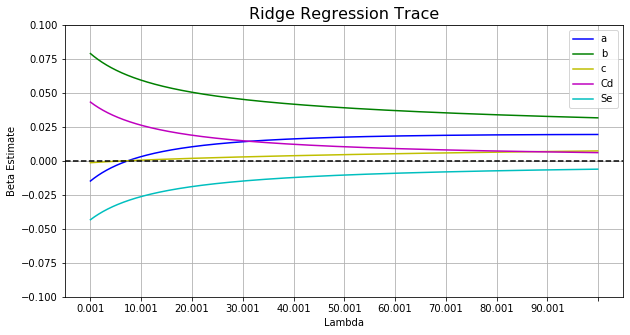

In [7]:
coef = band_gap_prediction_objects["Si2Ge3"].model_weights 

ridge_df = pd.DataFrame({'variable': feature_names, 'weights': coef})
ridge_train_pred = []
ridge_test_pred = []

X_train = band_gap_prediction_objects["Si2Ge3"].X_train
y_train = band_gap_prediction_objects["Si2Ge3"].y_train
X_test = band_gap_prediction_objects["Si2Ge3"].X_test
y_test = band_gap_prediction_objects["Si2Ge3"].y_test

alphas = np.arange(1e-3,1e2,0.1)

for alpha in alphas:
    ridge_reg = linear_model.Ridge(alpha=alpha)
    ridge_reg.fit(X_train, y_train)
    var_name = str(alpha)
    ridge_df[var_name] = ridge_reg.coef_
    
    # prediction
    ridge_train_pred.append(ridge_reg.predict(X_train))
    ridge_test_pred.append(ridge_reg.predict(X_test))
    
#ridge_df = ridge_df.set_index('variable').T.rename_axis('estimate').rename_axis(None, 1).reset_index()
del ridge_df['weights']
ridge_df = ridge_df.set_index('variable').T

fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(ridge_df.RM, 'r', ridge_df.ZN, 'g', ridge_df.RAD, 'b', ridge_df.CRIM, 'c', ridge_df.TAX, 'y')
ax.plot(
    ridge_df.a, "b",
    ridge_df.b, "g",
    ridge_df.c, "y",
    ridge_df.Si, "m",
    ridge_df.Ge, "c",
)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Lambda")
ax.set_ylabel("Beta Estimate")
ax.set_title("Ridge Regression Trace", fontsize=16)
ax.legend(labels=["a","b","c","Cd","Se"])
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.set_ylim(-0.1,0.1)
ax.grid(True)

In [7]:
# features that are the least efficient in your estimation will "shrink" the fastest
# the faster a coefficient is shrinking the less important it is in prediction